# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 5136384/11490434 [============>.................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:44 - loss: 0.6931

  35/1875 [..............................] - ETA: 2s - loss: 0.5214   

  61/1875 [..............................] - ETA: 3s - loss: 0.4586

  96/1875 [>.............................] - ETA: 2s - loss: 0.4128

 130/1875 [=>............................] - ETA: 2s - loss: 0.3853

 163/1875 [=>............................] - ETA: 2s - loss: 0.3660

 199/1875 [==>...........................] - ETA: 2s - loss: 0.3498

 234/1875 [==>...........................] - ETA: 2s - loss: 0.3371

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3270

 302/1875 [===>..........................] - ETA: 2s - loss: 0.3177

 340/1875 [====>.........................] - ETA: 2s - loss: 0.3089

 374/1875 [====>.........................] - ETA: 2s - loss: 0.3020

 411/1875 [=====>........................] - ETA: 2s - loss: 0.2953

 446/1875 [======>.......................] - ETA: 2s - loss: 0.2895

 478/1875 [======>.......................] - ETA: 2s - loss: 0.2847

 512/1875 [=======>......................] - ETA: 2s - loss: 0.2800

 545/1875 [=======>......................] - ETA: 1s - loss: 0.2757

 579/1875 [========>.....................] - ETA: 1s - loss: 0.2716

 613/1875 [========>.....................] - ETA: 1s - loss: 0.2678

 648/1875 [=========>....................] - ETA: 1s - loss: 0.2642

 681/1875 [=========>....................] - ETA: 1s - loss: 0.2609

 713/1875 [==========>...................] - ETA: 1s - loss: 0.2579

 748/1875 [==========>...................] - ETA: 1s - loss: 0.2549

 781/1875 [===========>..................] - ETA: 1s - loss: 0.2521

 815/1875 [============>.................] - ETA: 1s - loss: 0.2494

 855/1875 [============>.................] - ETA: 1s - loss: 0.2464

 889/1875 [=============>................] - ETA: 1s - loss: 0.2440

 917/1875 [=============>................] - ETA: 1s - loss: 0.2421

 946/1875 [==============>...............] - ETA: 1s - loss: 0.2402

 976/1875 [==============>...............] - ETA: 1s - loss: 0.2383

1009/1875 [===============>..............] - ETA: 1s - loss: 0.2363

1039/1875 [===============>..............] - ETA: 1s - loss: 0.2345

1073/1875 [================>.............] - ETA: 1s - loss: 0.2326

1103/1875 [================>.............] - ETA: 1s - loss: 0.2309

1130/1875 [=================>............] - ETA: 1s - loss: 0.2295

1159/1875 [=================>............] - ETA: 1s - loss: 0.2280

1192/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1223/1875 [==================>...........] - ETA: 1s - loss: 0.2249

1248/1875 [==================>...........] - ETA: 0s - loss: 0.2237

1273/1875 [===================>..........] - ETA: 0s - loss: 0.2226

1303/1875 [===================>..........] - ETA: 0s - loss: 0.2212

1331/1875 [====================>.........] - ETA: 0s - loss: 0.2200

1360/1875 [====================>.........] - ETA: 0s - loss: 0.2188

1395/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1419/1875 [=====================>........] - ETA: 0s - loss: 0.2164

1443/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1475/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1504/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1535/1875 [=======================>......] - ETA: 0s - loss: 0.2120

1566/1875 [========================>.....] - ETA: 0s - loss: 0.2109

1591/1875 [========================>.....] - ETA: 0s - loss: 0.2100

1623/1875 [========================>.....] - ETA: 0s - loss: 0.2090

1656/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1687/1875 [=========================>....] - ETA: 0s - loss: 0.2069

1718/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1751/1875 [===========================>..] - ETA: 0s - loss: 0.2049

1782/1875 [===========================>..] - ETA: 0s - loss: 0.2039

1815/1875 [============================>.] - ETA: 0s - loss: 0.2030

1848/1875 [============================>.] - ETA: 0s - loss: 0.2020

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2012


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1056

  33/1875 [..............................] - ETA: 2s - loss: 0.1122

  66/1875 [>.............................] - ETA: 2s - loss: 0.1116

 100/1875 [>.............................] - ETA: 2s - loss: 0.1108

 132/1875 [=>............................] - ETA: 2s - loss: 0.1104

 166/1875 [=>............................] - ETA: 2s - loss: 0.1100

 199/1875 [==>...........................] - ETA: 2s - loss: 0.1098

 232/1875 [==>...........................] - ETA: 2s - loss: 0.1096

 266/1875 [===>..........................] - ETA: 2s - loss: 0.1094

 298/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 331/1875 [====>.........................] - ETA: 2s - loss: 0.1091

 364/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 397/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 431/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 463/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 498/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 525/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 561/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 595/1875 [========>.....................] - ETA: 1s - loss: 0.1081

 630/1875 [=========>....................] - ETA: 1s - loss: 0.1080

 664/1875 [=========>....................] - ETA: 1s - loss: 0.1079

 698/1875 [==========>...................] - ETA: 1s - loss: 0.1078

 734/1875 [==========>...................] - ETA: 1s - loss: 0.1077

 769/1875 [===========>..................] - ETA: 1s - loss: 0.1076

 803/1875 [===========>..................] - ETA: 1s - loss: 0.1075

 838/1875 [============>.................] - ETA: 1s - loss: 0.1074

 872/1875 [============>.................] - ETA: 1s - loss: 0.1074

 905/1875 [=============>................] - ETA: 1s - loss: 0.1073

 940/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 975/1875 [==============>...............] - ETA: 1s - loss: 0.1071

1010/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1044/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1078/1875 [================>.............] - ETA: 1s - loss: 0.1069

1112/1875 [================>.............] - ETA: 1s - loss: 0.1068

1146/1875 [=================>............] - ETA: 1s - loss: 0.1067

1179/1875 [=================>............] - ETA: 1s - loss: 0.1067

1213/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1247/1875 [==================>...........] - ETA: 0s - loss: 0.1065

1282/1875 [===================>..........] - ETA: 0s - loss: 0.1065

1317/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1352/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1387/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1423/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1458/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1491/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1526/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1561/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1595/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1630/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1665/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1699/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1732/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1764/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1796/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1827/1875 [============================>.] - ETA: 0s - loss: 0.1055

1861/1875 [============================>.] - ETA: 0s - loss: 0.1054

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1054


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1022

  35/1875 [..............................] - ETA: 2s - loss: 0.0989

  69/1875 [>.............................] - ETA: 2s - loss: 0.0989

 101/1875 [>.............................] - ETA: 2s - loss: 0.0987

 133/1875 [=>............................] - ETA: 2s - loss: 0.0986

 166/1875 [=>............................] - ETA: 2s - loss: 0.0985

 200/1875 [==>...........................] - ETA: 2s - loss: 0.0985

 234/1875 [==>...........................] - ETA: 2s - loss: 0.0985

 266/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 299/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 332/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 397/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 557/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 591/1875 [========>.....................] - ETA: 1s - loss: 0.0983

 619/1875 [========>.....................] - ETA: 1s - loss: 0.0983

 646/1875 [=========>....................] - ETA: 1s - loss: 0.0983

 679/1875 [=========>....................] - ETA: 1s - loss: 0.0983

 708/1875 [==========>...................] - ETA: 1s - loss: 0.0983

 741/1875 [==========>...................] - ETA: 1s - loss: 0.0983

 772/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 805/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 837/1875 [============>.................] - ETA: 1s - loss: 0.0982

 868/1875 [============>.................] - ETA: 1s - loss: 0.0982

 900/1875 [=============>................] - ETA: 1s - loss: 0.0982

 932/1875 [=============>................] - ETA: 1s - loss: 0.0982

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1063/1875 [================>.............] - ETA: 1s - loss: 0.0981

1095/1875 [================>.............] - ETA: 1s - loss: 0.0981

1127/1875 [=================>............] - ETA: 1s - loss: 0.0981

1159/1875 [=================>............] - ETA: 1s - loss: 0.0981

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1250/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1276/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1303/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1333/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1363/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1431/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1835/1875 [============================>.] - ETA: 0s - loss: 0.0978

1869/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0972

  34/1875 [..............................] - ETA: 2s - loss: 0.0971

  67/1875 [>.............................] - ETA: 2s - loss: 0.0970

 100/1875 [>.............................] - ETA: 2s - loss: 0.0969

 133/1875 [=>............................] - ETA: 2s - loss: 0.0968

 166/1875 [=>............................] - ETA: 2s - loss: 0.0966

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0965

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0964

 264/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 296/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0961

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 523/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 620/1875 [========>.....................] - ETA: 1s - loss: 0.0959

 654/1875 [=========>....................] - ETA: 1s - loss: 0.0959

 686/1875 [=========>....................] - ETA: 1s - loss: 0.0959

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 751/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 818/1875 [============>.................] - ETA: 1s - loss: 0.0959

 852/1875 [============>.................] - ETA: 1s - loss: 0.0959

 886/1875 [=============>................] - ETA: 1s - loss: 0.0959

 920/1875 [=============>................] - ETA: 1s - loss: 0.0959

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1085/1875 [================>.............] - ETA: 1s - loss: 0.0958

1119/1875 [================>.............] - ETA: 1s - loss: 0.0958

1153/1875 [=================>............] - ETA: 1s - loss: 0.0958

1187/1875 [=================>............] - ETA: 1s - loss: 0.0958

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1254/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1287/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1322/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1542/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1819/1875 [============================>.] - ETA: 0s - loss: 0.0958

1849/1875 [============================>.] - ETA: 0s - loss: 0.0958

1873/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0964

  30/1875 [..............................] - ETA: 3s - loss: 0.0944

  56/1875 [..............................] - ETA: 3s - loss: 0.0944

  81/1875 [>.............................] - ETA: 3s - loss: 0.0943

 110/1875 [>.............................] - ETA: 3s - loss: 0.0944

 139/1875 [=>............................] - ETA: 3s - loss: 0.0945

 167/1875 [=>............................] - ETA: 3s - loss: 0.0945

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0946

 227/1875 [==>...........................] - ETA: 2s - loss: 0.0947

 255/1875 [===>..........................] - ETA: 2s - loss: 0.0947

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0948

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0948

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 580/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 611/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 640/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 674/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 709/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 741/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 806/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 839/1875 [============>.................] - ETA: 1s - loss: 0.0952

 873/1875 [============>.................] - ETA: 1s - loss: 0.0952

 906/1875 [=============>................] - ETA: 1s - loss: 0.0952

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1042/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1076/1875 [================>.............] - ETA: 1s - loss: 0.0952

1109/1875 [================>.............] - ETA: 1s - loss: 0.0952

1143/1875 [=================>............] - ETA: 1s - loss: 0.0952

1178/1875 [=================>............] - ETA: 1s - loss: 0.0952

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1279/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1313/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1346/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1839/1875 [============================>.] - ETA: 0s - loss: 0.0952

1871/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

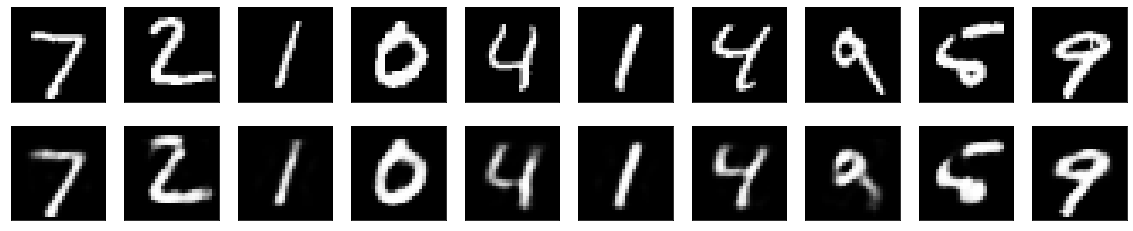

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
